# Import 

In [1]:
%matplotlib inline

import os
import math
from pathlib import Path
from functools import partial
from inspect import isfunction

import cv2
import matplotlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from data_loader import make_data_loader

# Parameter

In [2]:
device = 'cuda'
image_size = 64
batch_size = 128

model_path = './weight/log23_S2074_cfg_step_100000.pth' # disentangle loss なし, 2074font, Aのみ

channels = 1
unet_dim = 32
timesteps = 1000
cond_drop_prob = 0.1
unet_dim_mults = (1, 2, 4, 8,)
num_style = int(model_path.split('/')[-1].split('_')[1][1:])

# define betas
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる
log_one_minus_alphas_cumprod = torch.log(1. - alphas_cumprod)
sqrt_recip_alphas_cumprod = torch.sqrt(1. / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / alphas_cumprod - 1)

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, style, t, t_index, style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, style, style_scale=style_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, style, shape, style_scale=6., rescaled_phi=0.7):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, style, torch.full((b,), i, device=device, dtype=torch.long), i, style_scale=style_scale, rescaled_phi=rescaled_phi)
    return img

@torch.no_grad()
def sample(model, style, image_size, batch_size=16, channels=3, style_scale=6., rescaled_phi=0.7, is_ddim_sampling=False):
    if is_ddim_sampling == False:
        return p_sample_loop(model, style, shape=(batch_size, channels, image_size, image_size), style_scale=style_scale, rescaled_phi=rescaled_phi)
    else:
        return ddim_sample(model, style, style_scale=style_scale)

@torch.no_grad()
def ddim_sample(model, style, style_scale = 1.):
    batch, total_timesteps, sampling_timesteps, eta = style.shape[0], timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    img = torch.randn((batch, 1, image_size, image_size), device = device)

    x_start = None

    for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
        t = torch.full((batch,), time, device=device, dtype=torch.long)
        pred_noise = model.forward_with_cond_scale(img, t, style, style_scale=style_scale, rescaled_phi=0.)
        x_start  = extract(sqrt_recip_alphas_cumprod, t, img.shape) * img -\
                        extract(sqrt_recipm1_alphas_cumprod, t, img.shape) * pred_noise

        if time_next < 0:
            img = x_start
            continue

        alpha = alphas_cumprod[time]
        alpha_next = alphas_cumprod[time_next]

        sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
        c = (1 - alpha_next - sigma ** 2).sqrt()

        noise = torch.randn_like(img)

        img = x_start * alpha_next.sqrt() + \
                c * pred_noise + \
                sigma * noise

    return img

@torch.no_grad()
def p_sample_noise_interpolate(model, x, style1, style2, t, style_scale, alpha=0.5):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # predict noise
    style1_noise = model.forward_with_cond_scale(x, t, style1, style_scale=style_scale, rescaled_phi=0.)
    style2_noise = model.forward_with_cond_scale(x, t, style2, style_scale=style_scale, rescaled_phi=0.)

    # style interpolation
    pred_noise = alpha * style1_noise + (1 - alpha) * style2_noise

    # sampling
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

def imscatter(x,y,image_list,_ax=None,zoom=0.2,color=['black']):
    for i in range(len(image_list)):
        if len(color) < len(image_list):
            color.append(color[0])
        if _ax is None:
            _ax = plt.gca()
        image = image_list[i] #plt.imread(image_list[i])
        im = OffsetImage(image,zoom=zoom)
        artists = []
        x0 = x[i]
        y0 = y[i]
        ab = AnnotationBbox(im,(x0,y0),xycoords='data',frameon=True,bboxprops=dict(color=color[i]))
        artists.append(_ax.add_artist(ab))
    return artists

# Load data

In [11]:
dataloader = make_data_loader(batch_size, image_size, num_style)['train']
d = dataloader.dataset

TRAIN SIZE: 2074
TEST SIZE: 0


# Load trained model

In [4]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_style=num_style,
    cond_drop_prob=cond_drop_prob,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f'ok {model_path}')

ok ./weight/log23_S2074_cfg_step_100000.pth


# L1

In [13]:
with open('result/eval.txt', 'a') as f:
    f.write('\n============\n')
    f.write(f"{model_path.split('/')[-1]}\n")

for scale in [1., 3., 5., 7.]:
    style_scale = scale
    rescaled_phi = 0.

    loss = nn.L1Loss()
    total_loss = 0.

    for gt, s in dataloader:
        gt = gt.to(device)
        s = s.to(device)
        output = sample(model, s, image_size=image_size, batch_size=gt.size(0), channels=channels,
                        style_scale=style_scale, rescaled_phi=rescaled_phi, is_ddim_sampling=False)

        total_loss += loss(torch.clamp(output, min=-1., max=1.), gt).item() * gt.size(0)
        break

    total_loss /= len(dataloader.dataset)

    # eval.txt は全モデルで共通
    with open('result/eval.txt', 'a') as f:
        f.write(f'\tscale: {scale}, l1 loss: {total_loss}\n')

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

# condition 指定して生成

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

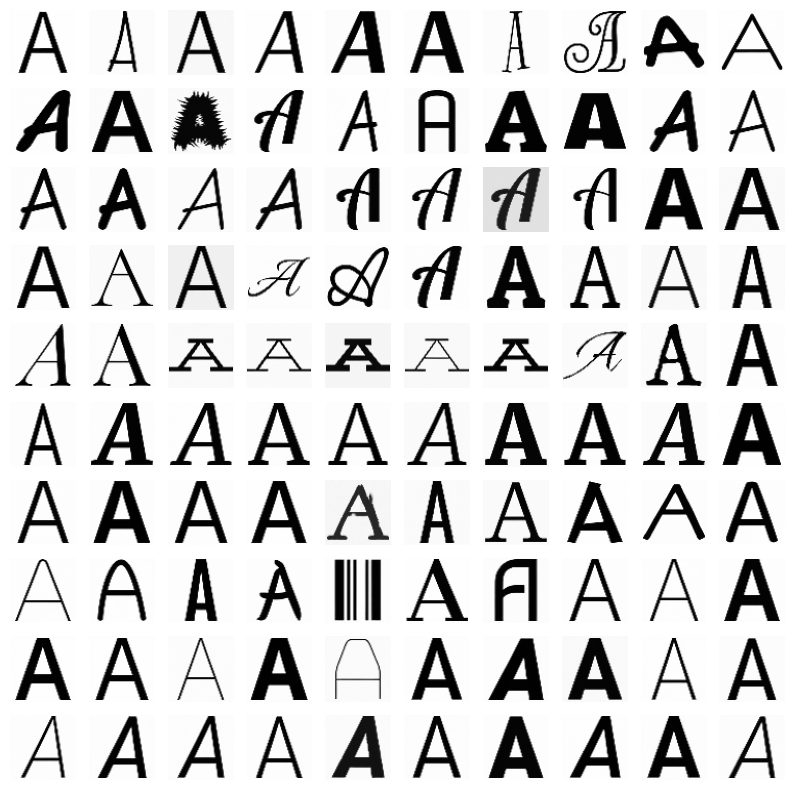

In [9]:
style_scale = 1.
rescaled_phi = 0.
ddim_sampling = False

if ddim_sampling == False:
    save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_none+[s-none]_{style_scale}.png"
else:
    save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_ddim_{style_scale}.png"

scale_list = [15]

for ss in scale_list:
    b = 100
    classes = torch.full((b,), 0, device=device, dtype=torch.long)
    style = torch.tensor([i for i in range(b)], device=device, dtype=torch.long)
    samples = sample(model, style, image_size=image_size, batch_size=b, channels=channels,
                    style_scale=ss, rescaled_phi=rescaled_phi, is_ddim_sampling=ddim_sampling)

    # show images
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        x = i // 10
        y = i % 10
        ax[x, y].axis("off")
        ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

    plt.savefig(save_path1)
    plt.show()


# GT

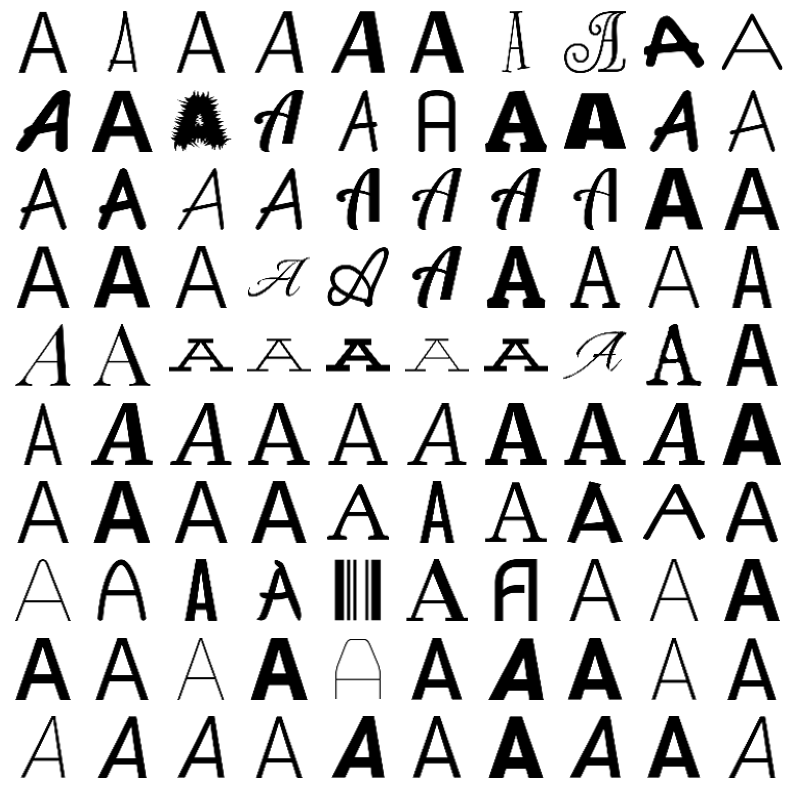

In [8]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[i][0][0], cmap='gray')

# ノイズの内挿

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

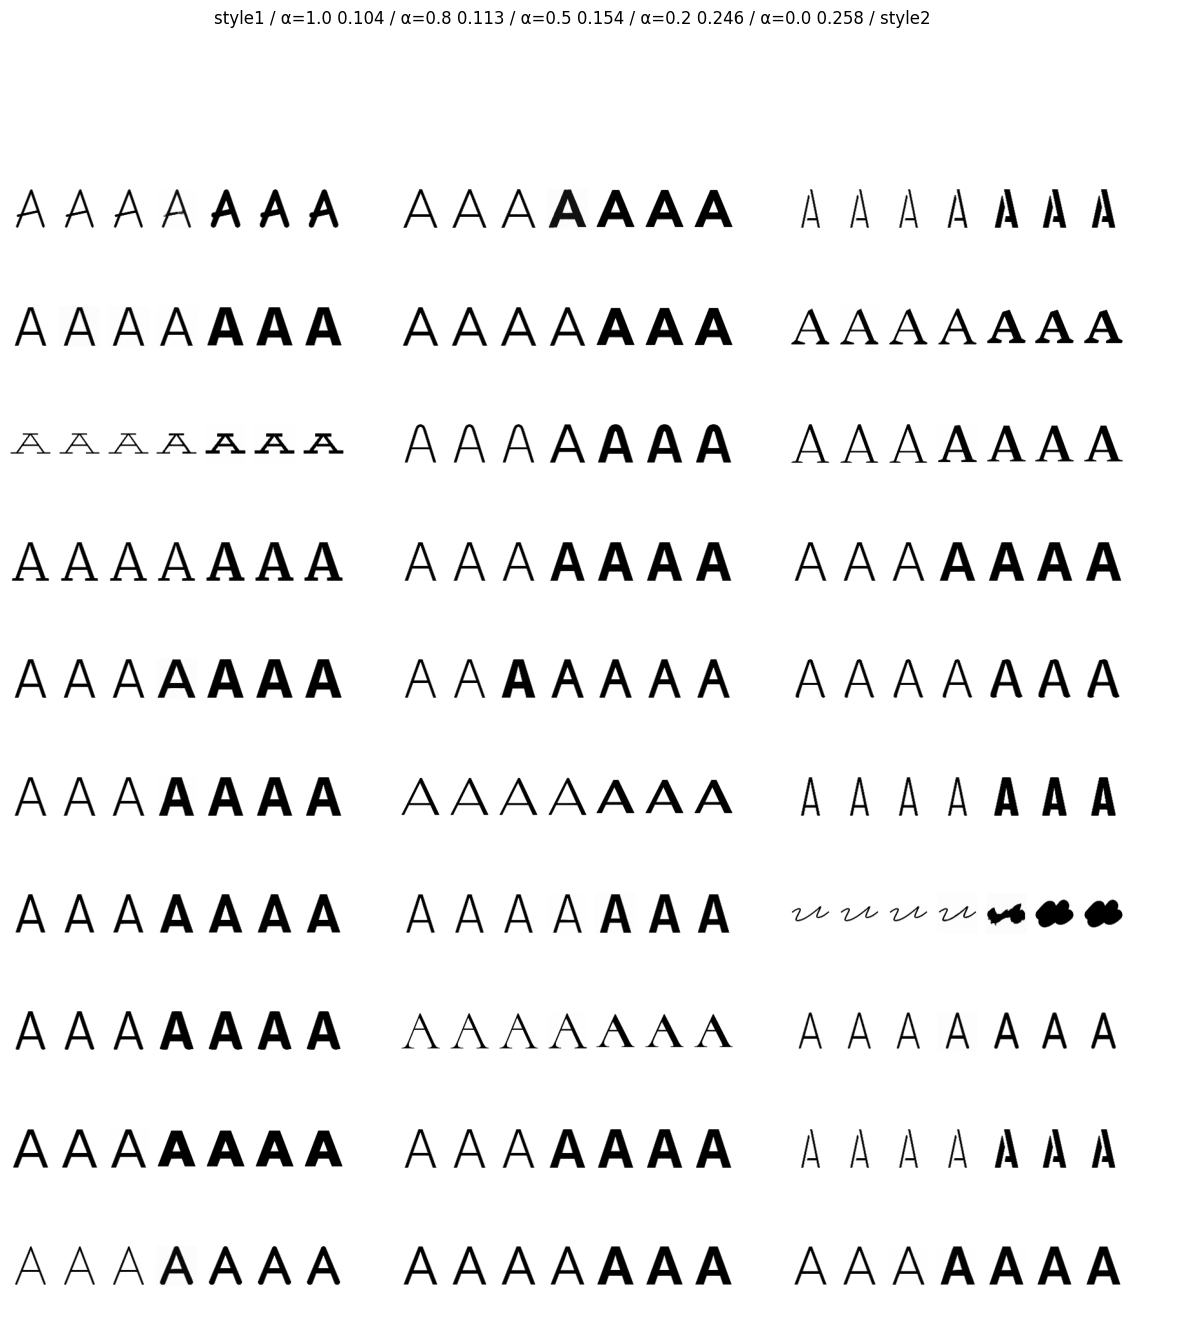

In [7]:
data_dict = {}
weight_cnt = {}

# 学習データ（1000データ）からfontfのidを取得
df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
style_i = 0
for data_type in ['train']:
    data_type_df = df[df['data_type'] == data_type]

    for i in range(len(data_type_df)):
        if style_i >= num_style: break
        p = os.path.join('../font2img/image', data_type_df.loc[i, 'font'])
        if os.path.isdir(p) == False: continue

        if '-' in data_type_df.loc[i, 'font']:
            fontfamily = data_type_df.loc[i, 'font'].split('-')[0]
            weight = data_type_df.loc[i, 'font'].split('-')[1]
            if fontfamily in data_dict:
                data_dict[fontfamily][weight] = style_i
            else:
                data_dict[fontfamily] = {weight: style_i}

            if weight in weight_cnt:
                weight_cnt[weight] += 1
            else:
                weight_cnt[weight] = 1

        style_i += 1

# print(data_dict)
# print(weight_cnt)

# 3種類のweightを持つfontのみを抽出
pair_data_list = []
for font, weights in data_dict.items():
    if 'Bold' in weights and 'Regular' in weights and 'Light' in weights:
        pair_data_list.append({'Bold': weights['Bold'], 'Regular': weights['Regular'], 'Light': weights['Light']})

# print(pair_data_list)

# 内挿
style_scale = 3.
#0 よりはstyle2, 1 よりはstyle1

b = 30
img = torch.randn((b, channels, image_size, image_size), device=device)
style1 = torch.tensor([pair_data_list[i]['Light'] for i in range(b)], device=device, dtype=torch.long)
style2 = torch.tensor([pair_data_list[i]['Bold'] for i in range(b)], device=device, dtype=torch.long)
gt = torch.cat([d[pair_data_list[i]['Regular']][0] for i in range(b)]).unsqueeze(1).to(device)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_noise_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

loss_alpha = {}
for a in img_alpha.keys():
    loss_alpha[a] = nn.L1Loss()(torch.clamp(img_alpha[a], min=-1., max=1.), gt)

fig, ax = plt.subplots(10, 8*(b//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2[i]][0][0], cmap='gray')

title = 'style1 / '
for a in img_alpha.keys():
    title += f'α={a} {loss_alpha[a] :.3f} / '
title += 'style2'

fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_scale{style_scale}.png")
plt.show()


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

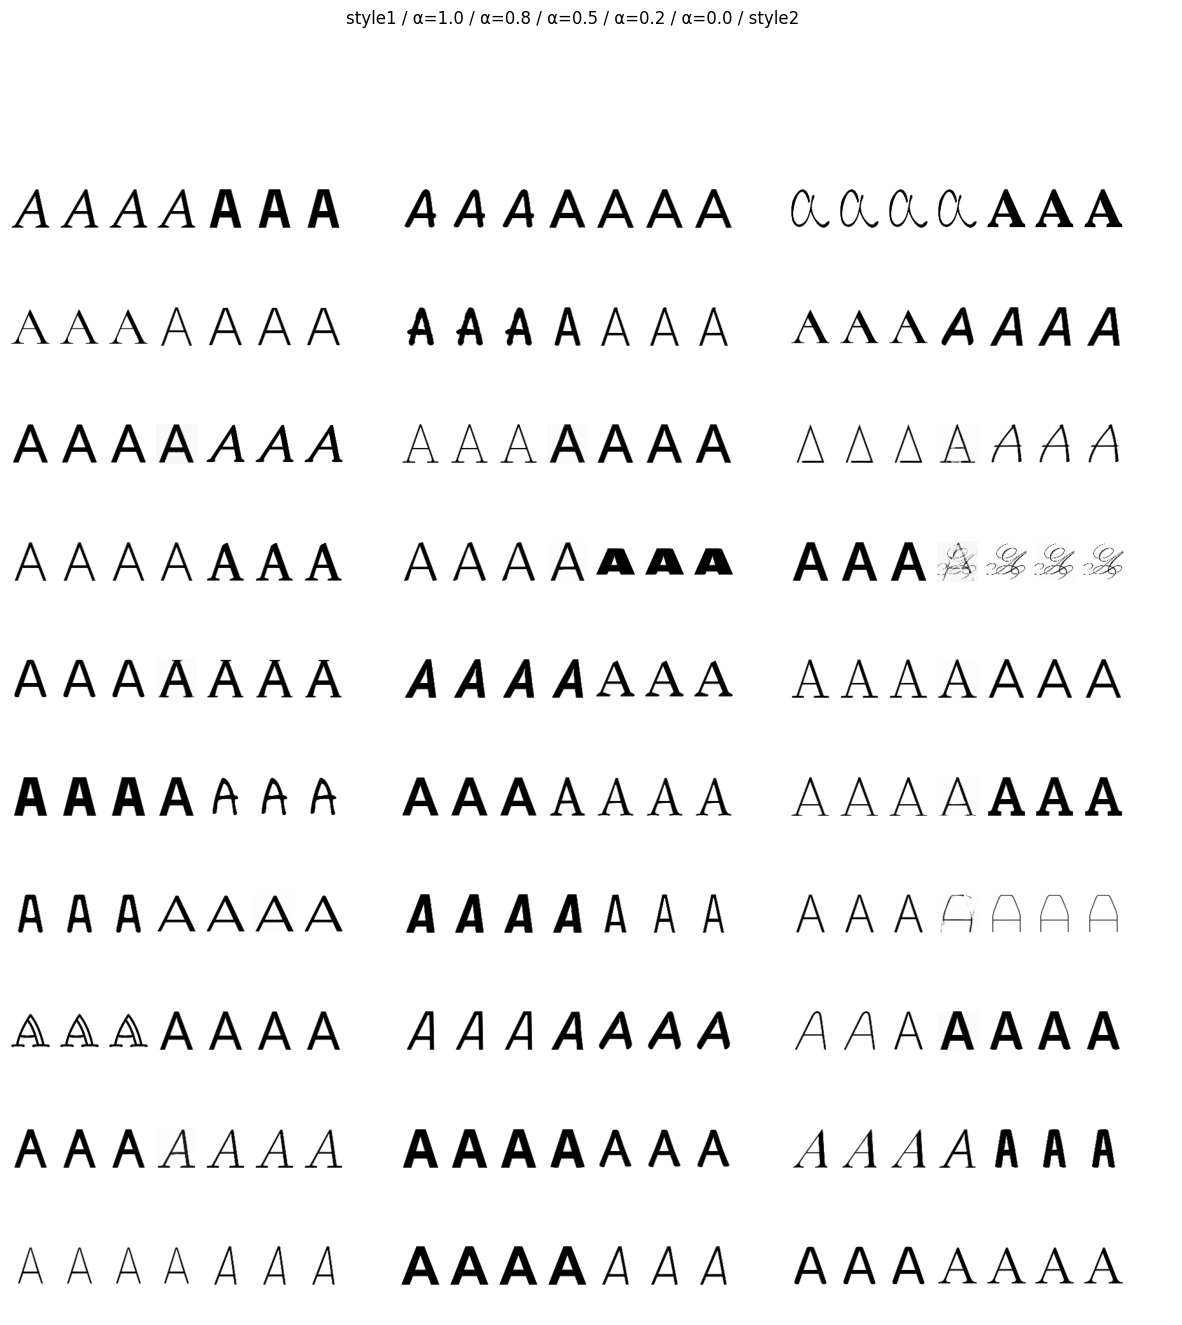

In [5]:
# いろんなフォントの内挿
# 内挿
# 両方 0 のとき, ε(s, c)になる
#0 よりはstyle2, 1 よりはstyle1
style_scale = 3.

b = 30
img = torch.randn((b, channels, image_size, image_size), device=device)
style1 = torch.randint(0, num_style, (b,), device=device, dtype=torch.long)
style2 = torch.randint(0, num_style, (b,), device=device, dtype=torch.long)

img_alpha = {a: img for a in [1., 0.8, 0.5, 0.2, 0.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_alpha.keys():
        img_alpha[a] = p_sample_noise_interpolate(model, img_alpha[a], style1, style2, t, style_scale=style_scale, alpha=a)

fig, ax = plt.subplots(10, 8*(b//10), figsize=(15, 15))
for i in range(b):
    for j in range(8):
        ax[i%10, 8*(i//10)+j].axis('off')

    ax[i%10, 8*(i//10)+0].imshow(d[style1[i]][0][0], cmap='gray')
    for j, a in enumerate(img_alpha.keys()):
        ax[i%10, 8*(i//10)+j+1].imshow(img_alpha[a][i][0].cpu().detach().clone(), cmap='gray')
    ax[i%10, 8*(i//10)+6].imshow(d[style2[i]][0][0], cmap='gray')

title = 'style1 / '
for a, loss in img_alpha.items():
    title += f'α={a} / '
title += 'style2'
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_id{style1.sum()}.png")

# ノイズの演算

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

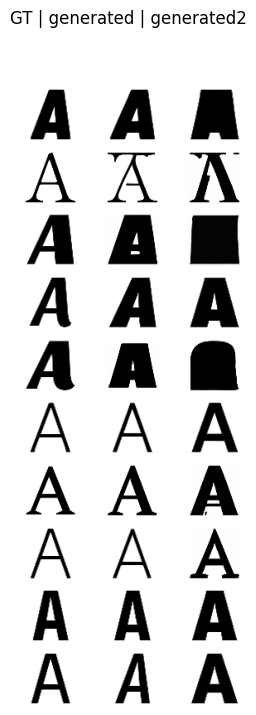

In [6]:
light_id = 60
bold_id = 61

style_scale = 3.

b = 10
img = torch.randn((b, channels, image_size, image_size), device=device)
img2 = torch.randn((b, channels, image_size, image_size), device=device)
style = torch.randint(0, 1000, (b,), device=device, dtype=torch.long)
light_style = torch.tensor([light_id for i in range(b)], device=device, dtype=torch.long)
bold_style = torch.tensor([bold_id for i in range(b)], device=device, dtype=torch.long)


for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    betas_t = extract(betas, t, img.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, img.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, img.shape)

    with torch.no_grad():
        # 単純にsampling
        pred_noise = model.forward_with_cond_scale(img, t, style, style_scale=style_scale, rescaled_phi=0.)
        model_mean = sqrt_recip_alphas_t * (img - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        # bold - light のノイズを加える
        bold_noise = model.forward_with_cond_scale(img2, t, bold_style, style_scale=style_scale, rescaled_phi=0.)
        light_noise = model.forward_with_cond_scale(img2, t, light_style, style_scale=style_scale, rescaled_phi=0.)
        pred_noise2 = model.forward_with_cond_scale(img2, t, style, style_scale=style_scale, rescaled_phi=0.)
        pred_noise2 = pred_noise2 + (bold_noise - light_noise)
        model_mean2 = sqrt_recip_alphas_t * (img2 - betas_t * pred_noise2 / sqrt_one_minus_alphas_cumprod_t)

    if i == 0:
        img = model_mean
        img2 = model_mean2
    else:
        posterior_variance_t = extract(posterior_variance, t, img.shape)
        noise = torch.randn_like(img)
        img = model_mean + torch.sqrt(posterior_variance_t) * noise
        img2 = model_mean2 + torch.sqrt(posterior_variance_t) * noise

fig, ax = plt.subplots(b, 3, figsize=(3, int(b*0.8)))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(img2[i][0].cpu().detach().clone(), cmap='gray')
fig.suptitle(f'GT | generated | generated2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_operation_scale{style_scale}_id{style.sum()}.png")